In [1]:
# uncomment and run this code to download the flickr-8 audio corpus
# alternatively, just go to this link and download the data here https://drive.google.com/drive/folders/1ZucIf6bk0HXQt2mqpY_HPAHWP9UhUg6s?usp=sharing

# import gdown

# url = 'https://drive.google.com/uc?id=1ST6aZkNRH_iUbYjjOnXjpk3uRw5nHo7g'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)

# url = 'https://drive.google.c?om/uc?id=1DfH8pY5cr2fvTlLQwrlIcBuFUFrGuvi1'
# output = 'bytefuse_searchEngine_hackathon_meta.csv'
# gdown.download(url, output, quiet=False)


# !unzip data.zip

# Introduction

Welcome to the [ByteFuse AI](https://bytefuse.ai/) Llama hackathon. This hackathon differs from other machine learning hackathons in that we want you to focus on what you can do with models, rather than on model design and training.

To understand the goal of this hackathon, put yourself in the shoes of one of the engineers at ByteFuse. You arrive at the office one morning with the news that one of the research scientists has begun developing a system capable of performing multimodal search over both images and speech. The scientist was only able to partially train the system on the [Flickr Audio Caption Corpus](https://groups.csail.mit.edu/sls/downloads/flickraudio/) due to budget constraints. This means that the models are not optimal, but if one searches for a dog, one will get images for dogs back, but fine-grained detail, such as requesting two dogs, will be missed.

The research scientist approaches you, asking if you can create a proof of concept (POC) for a product using the system in order to demonstrate to the people at the top that his system will not be a bad investment. The scientist tells you that the only constraint for the product is that it performs multimodal search, either speech->image, image->speech, or both directions. Despite the scientist's belief that the models provided will be a good starting point, the product does not have to be built using the models provided. You can either fine-tune the models further or design entirely new model architectures.

This is a common scenario at ByteFuse, where we are tasked with finding practical applications for machine learning systems. We want you to experience this rush.  Take our models, or don't, and wow us with your work! The panel will not be judging how well the machine learning component works, but rather how novel the idea is and how well the product as concept works.

This notebook will serve as a guide on how to use some of the utility functions provided. If you want insparation on methods that you could use to fine these models, refer to our introduction notebook on multimodal search [here](https://colab.research.google.com/drive/1fIfHKOJBhHvFzAYwkDZwAobKNgeEzDsf?usp=sharing).

# Setting up the environement

In [2]:
import os
import argparse
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio

import IPython.display as ipd

# if you are in the same directory as the utils file
from utils import process_audio, process_image, return_pretrained_models

In [3]:
def draw_subplots(data):
    
  plt.figure(figsize=(10,10))

  plt.subplot(2, 2, 1)
  plt.imshow(data[0], cmap='gray')
  plt.axis('off')

  plt.subplot(2, 2, 2)
  plt.imshow(data[1], cmap='gray')
  plt.axis('off')

  plt.subplot(2, 2, 3)
  plt.imshow(data[2], cmap='gray')
  plt.axis('off')

  plt.subplot(2, 2, 4)
  plt.imshow(data[3], cmap='gray')
  plt.axis('off')
  plt.show()

# Loading in our pretrained models

As mentioned above, our research scientist has managed to train a speech and image model, to a relatively ok state. This means that a lot of improvement can be made on them, but it is not nescarry to only build a POC to show the idea for your product. 

But remember, if you want to improve on them then go for it!

In [4]:
# load the models with the utility function
audio_model, image_model = return_pretrained_models(root_path_to_weights='./model_weights/')

# Creating a mini database of flickr audio and image

Here we will sample from data from the flickr dataset and generate representations for them, and add it to our "database" that we can use when we build a search engine.


Below we read in our data and show what was used for training, and what was used for validation and testing during the research scientists model training phase. For our database, we will take all the validation and test cases.

In [5]:
# if you have downloaded the data using the top cell of the notebook to your current folder
df = pd.read_csv('./bytefuse_searchEngine_hackathon_meta.csv')
df

,audio_file,image_file,caption_number,id_,split
0,2571096893_694ce79768_1.wav,2571096893_694ce79768.jpg,1,2571096893_694ce79768,train
1,2571096893_694ce79768_2.wav,2571096893_694ce79768.jpg,2,2571096893_694ce79768,train
2,2570559405_dc93007f76_4.wav,2570559405_dc93007f76.jpg,4,2570559405_dc93007f76,train
3,2571096893_694ce79768_0.wav,2571096893_694ce79768.jpg,0,2571096893_694ce79768,train
4,2572101672_4d699c8713_0.wav,2572101672_4d699c8713.jpg,0,2572101672_4d699c8713,train
...,...,...,...,...,...
39995,534669139_1a4f8ab9d5_1.wav,534669139_1a4f8ab9d5.jpg,1,534669139_1a4f8ab9d5,test
39996,534669139_1a4f8ab9d5_4.wav,534669139_1a4f8ab9d5.jpg,4,534669139_1a4f8ab9d5,test
39997,534669139_1a4f8ab9d5_3.wav,534669139_1a4f8ab9d5.jpg,3,534669139_1a4f8ab9d5,test
39998,534875358_6ea30d3091_1.wav,534875358_6ea30d3091.jpg,1,534875358_6ea30d3091,validation


In [6]:
# split data and generate embeddings
df = df[df.split.isin(['test', 'validation'])]

Of course the below can be sped up by batching you data and some few other trick, but that is left for you to optimize.

In [7]:
audio_files = df.audio_file.values

representations = []
for audio_file in tqdm(audio_files):
    audio = process_audio(audio_path=f'./flickr_audio_8k/{audio_file[:-6]}/{audio_file}')
    with torch.no_grad():
        representations.append(audio_model(audio.unsqueeze(0))[0].numpy())
        
audio_embeddings = torch.tensor(representations)
audio_embeddings = F.normalize(audio_embeddings, p=2, dim=1)

100%|██████████| 10000/10000 [21:26<00:00,  7.77it/s]


In [8]:
image_files = df.drop_duplicates('image_file').image_file.values


representations = []
for image_file in tqdm(image_files):
    image = process_image(image_path=f'./flickr_audio_8k/{image_file[:-4]}/{image_file}')
    with torch.no_grad():
        representations.append(image_model(image.unsqueeze(0))[0].numpy())
        
image_embeddings = torch.tensor(representations)
image_embeddings = F.normalize(image_embeddings, p=2, dim=1)

100%|██████████| 2000/2000 [00:55<00:00, 35.77it/s]


# Doing searches

The models were trained to find similar points using cosine similarity. Because we normalized our database in the code above, we can speed up big calculations over our database by doing matrix multiplications when we have a target embedding. 

This is shown in the code below, were we first read in a image and recording from the flickr dataset, then we perform image->speech and speech->image search. You will notice that these partially trained models seem to do better in the image->speech search. Could you improve the speech->image?

Target speech


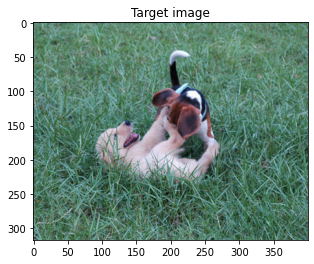

In [15]:
root = './flickr_audio_8k/'
id_ = '23445819_3a458716c1'

image_path = os.path.join(root, id_,f'{id_}.jpg')
audio_path = os.path.join(root, id_,f'{id_}_0.wav') # you can choose between [0,1,2,3,4]


image = torchvision.io.read_image(image_path)
plt.title('Target image')
plt.imshow(image.permute(1,2,0))

print('Target speech')
audio_, sr = torchaudio.load(audio_path) 
ipd.display(ipd.Audio(audio_[0], rate=16e3))

image = process_image(image_path=os.path.join(image_path))
audio = process_audio(audio_path=os.path.join(audio_path))
                      
with torch.no_grad():
    target_image_embedding = image_model(image.unsqueeze(0))
    target_image_embedding = F.normalize(target_image_embedding, p=2, dim=1)
    
with torch.no_grad():
    target_audio_embedding = audio_model(audio.unsqueeze(0))
    target_audio_embedding = F.normalize(target_audio_embedding, p=2, dim=1)

Below we do speech->image search

Closest images


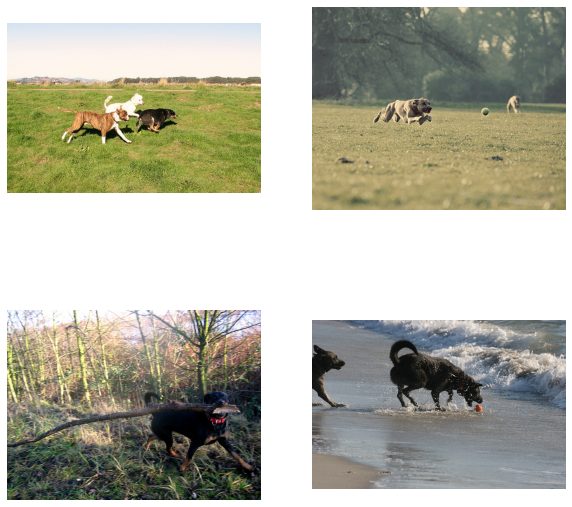

Farthest images


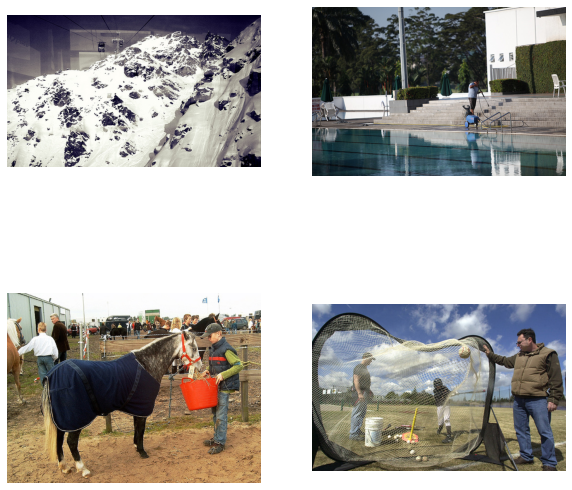

In [16]:
def get_image(loc):
    image = torchvision.io.read_image(f'flickr_audio_8k/{loc[:-4]}/{loc}')
    return image

with torch.no_grad():
    dist = (image_embeddings @ target_audio_embedding.T)

index_sorted = torch.argsort(torch.abs(dist).squeeze(-1))
top_5 = index_sorted[-5:]
bottom_5 = index_sorted[:5]



print('Closest images')
draw_subplots([get_image(image_files[i]).permute(1,2,0) for i in top_5])


print('Farthest images')
draw_subplots([get_image(image_files[i]).permute(1,2,0) for i in bottom_5])

Below we do image->speech search

In [17]:
with torch.no_grad():
    dist = (audio_embeddings @ target_image_embedding.T)
        
index_sorted = torch.argsort(dist.squeeze(-1))
top_5 = index_sorted[-5:]
bottom_5 = index_sorted[:5]

import IPython.display as ipd

print('3 Closest audio')

for i in range(3):
    audio_file = audio_files[top_5[i]]
    audio_, sr = torchaudio.load(f'/home/rvdmerwe/Downloads/flickr_audio/flickr_audio_8k/{audio_file[:-6]}/{audio_file}')
    ipd.display(ipd.Audio(audio_[0], rate=sr))
    print()


print('3 most different audio')
for i in range(3):
    audio_file = audio_files[bottom_5[i]]
    audio_, sr = torchaudio.load(f'/home/rvdmerwe/Downloads/flickr_audio/flickr_audio_8k/{audio_file[:-6]}/{audio_file}')
    ipd.display(ipd.Audio(audio_[0], rate=sr))

3 Closest audio



3 most different audio


# Conclusion

This should be enough now to get you go going. Remember, ANYTHING is allowed. Search just means finding similar things, so how can you then use that concept to build a POC.

We look forward to what you bring us!!